# 分布建模
## 指数分布
$CDF(x)=1-e^{-\lambda x}$

- 参数$\lambda$决定分布形状，可以解释为一个比率，即事件在一个时间单元内发生的平均次数。下例中，24小时内出生了44个婴儿，因此这个比率为$\lambda$等于每分钟0.0306个婴儿出生。指数分布的均值为$\frac{1}{\lambda}$，故婴儿出生时间的间隔均值为32.7分钟。
- 对事件发生的时间间隔，即达到间隔（interarrival time）进行测量，可能会得到指数分布。
- 如果事件在任意时间发生的可能性相同，到达间隔的分布就会近似一个指数分布。

In [1]:
%matplotlib inline
from __future__ import print_function, division

import numpy as np
import pandas
import thinkstats2
import thinkplot
import nsfg

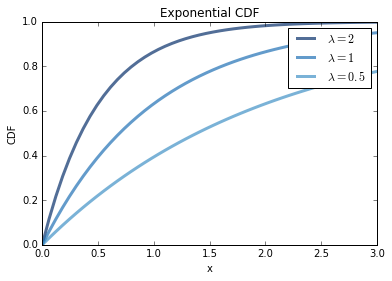

In [2]:
"""Generates a plot of the exponential CDF."""

thinkplot.PrePlot(3)
for lam in [2.0, 1, 0.5]:
    xs, ps = thinkstats2.RenderExpoCdf(lam, 0, 3.0, 50)
    label = r'$\lambda=%g$' % lam
    thinkplot.Plot(xs, ps, label=label)

thinkplot.Config(title='Exponential CDF',
               xlabel='x',
               ylabel='CDF')

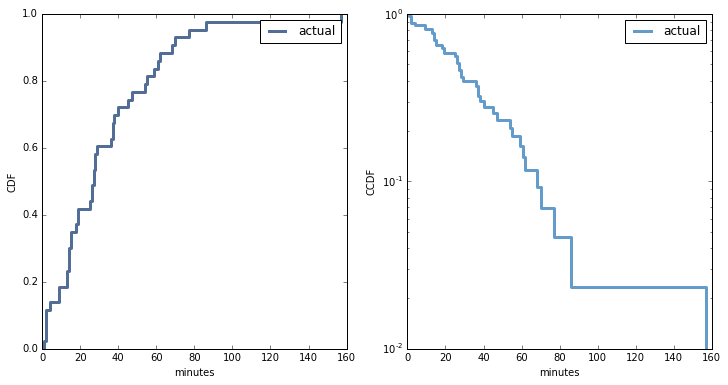

In [3]:
def ReadBabyBoom(filename='babyboom.dat'):
    """Reads the babyboom data.

    filename: string

    returns: DataFrame
    """
    var_info = [
        ('time', 1, 8, int),
        ('sex', 9, 16, int),
        ('weight_g', 17, 24, int),
        ('minutes', 25, 32, int),
        ]
    columns = ['name', 'start', 'end', 'type']
    variables = pandas.DataFrame(var_info, columns=columns)
    variables.end += 1
    dct = thinkstats2.FixedWidthVariables(variables, index_base=1)

    df = dct.ReadFixedWidth(filename, skiprows=59)
    return df

def MakeBabyBoom():
    """Plot CDF of interarrival time on log and linear scales.
    """
    # compute the interarrival times
    df = ReadBabyBoom()
    diffs = df.minutes.diff()
    cdf = thinkstats2.Cdf(diffs, label='actual')

    thinkplot.PrePlot(cols=2)
    thinkplot.Cdf(cdf)
    thinkplot.Config(xlabel='minutes',
                     ylabel='CDF',
                     legend=False)

    thinkplot.SubPlot(2)
    thinkplot.Cdf(cdf, complement=True)
    thinkplot.Config(xlabel='minutes',
                     ylabel='CCDF',
                     yscale='log',
                     legend=False)
MakeBabyBoom()

左图展示婴儿出生到达间隔的CDF。验证指数分布方法：以log-y为纵轴，绘制CDF补函数(complementary CDF, CCDF)，即1-CDF(x)，对指数分布的数据，绘制结果将是一条直线。

$y \approx e^{-\lambda x}$

两边取对数：$logy \approx -\lambda x$

右图中的线不是很直，说明指数分布并不是这组数据的完美模型。之前的假设——婴儿在一天中的任何时间出生的可能性相同，可能并不成立。

## 正态分布
- CDF(0)=0.5：标准正态分布的中位数是0（与均值相同），分布中一般的值小于中位数。

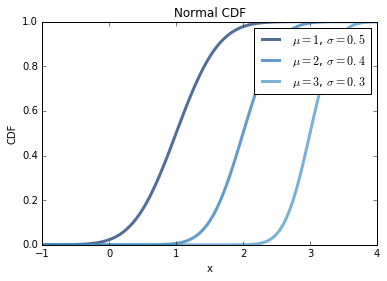

In [4]:
thinkplot.PrePlot(3)

mus = [1.0, 2.0, 3.0]
sigmas = [0.5, 0.4, 0.3]
for mu, sigma in zip(mus, sigmas):
    xs, ps = thinkstats2.RenderNormalCdf(mu=mu, sigma=sigma, 
                                           low=-1.0, high=4.0)
    label = r'$\mu=%g$, $\sigma=%g$' % (mu, sigma)
    thinkplot.Plot(xs, ps, label=label)

thinkplot.Config(root='analytic_normal_cdf',
               title='Normal CDF',
               xlabel='x',
               ylabel='CDF',
               loc=2)

Mean, Var 7.28088310002 1.54521257035
Sigma 1.24306579486


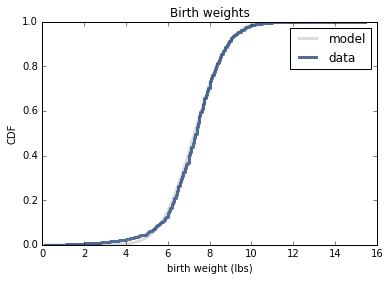

In [5]:
import math
def MakeNormalModel(weights):
    """Plot the CDF of birthweights with a normal model."""
    
    # estimate parameters: trimming outliers yields a better fit
    mu, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
    print('Mean, Var', mu, var)
    
    # plot the model
    sigma = math.sqrt(var)
    print('Sigma', sigma)
    xs, ps = thinkstats2.RenderNormalCdf(mu, sigma, low=0, high=12.5)

    thinkplot.Plot(xs, ps, label='model', color='0.8')

    # plot the data
    cdf = thinkstats2.Cdf(weights, label='data')

    thinkplot.PrePlot(1)
    thinkplot.Cdf(cdf) 
    thinkplot.Config(root='analytic_birthwgt_model',
                   title='Birth weights',
                   xlabel='birth weight (lbs)',
                   ylabel='CDF')

# test the distribution of birth weights for normality
preg = nsfg.ReadFemPreg()
full_term = preg[preg.prglngth >= 37]

weights = preg.totalwgt_lb.dropna()
term_weights = full_term.totalwgt_lb.dropna()

MakeNormalModel(weights)

上图展示所有成功生产的新生儿童体重的经验CDF，以及具有相同均值和方差的正态分布的CDF。在低于第10百分位数的部分，数据和模型之间存在差距。相比正态分布中的期望值，实际数据中体重较轻的新生儿更多。

## 正态概率图
- 验证一个正态分布模型是否适用于一个数据集。
- 简单方法如下：
    1. 将样本中的值排序
    2. 从一个标准正态分布($\mu=0,\sigma=1$)，生成一个随机样本并排序，样本大小与需要建模的样本一样
    3. 绘制样本的排序值和随机值

如果样本的分布接近正态分布，那么绘制结果将为一条直线，截距为mu，斜率为sigma。

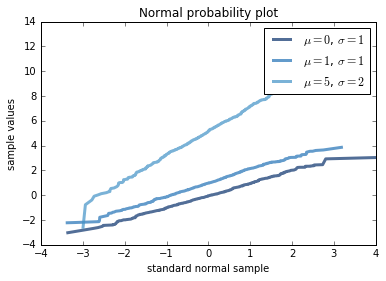

In [6]:
n = 1000
thinkplot.PrePlot(3)

mus = [0, 1, 5]
sigmas = [1, 1, 2]
for mu, sigma in zip(mus, sigmas):
    sample = np.random.normal(mu, sigma, n)
    xs, ys = thinkstats2.NormalProbability(sample)
    label = '$\mu=%d$, $\sigma=%d$' % (mu, sigma)
    thinkplot.Plot(xs, ys, label=label)

thinkplot.Config(root='analytic_normal_prob_example',
               title='Normal probability plot',
               xlabel='standard normal sample',
               ylabel='sample values')

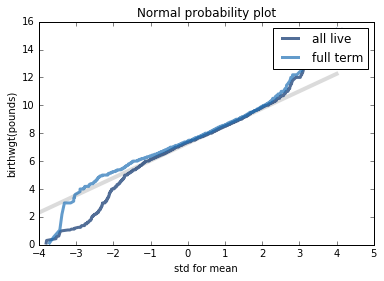

In [7]:
def MakeNormalPlot(weights, term_weights):
    """Generates a normal probability plot of birth weights."""

    mean, var = thinkstats2.TrimmedMeanVar(weights, p=0.01)
    std = math.sqrt(var)

    xs = [-4, 4]
    fxs, fys = thinkstats2.FitLine(xs, mean, std)
    thinkplot.Plot(fxs, fys, linewidth=4, color='0.8')

    thinkplot.PrePlot(2)
    xs, ys = thinkstats2.NormalProbability(weights)
    thinkplot.Plot(xs, ys, label='all live')

    xs, ys = thinkstats2.NormalProbability(term_weights)
    thinkplot.Plot(xs, ys, label='full term')
    thinkplot.Config(title='Normal probability plot',
               xlabel='std for mean',
               ylabel='birthwgt(pounds)')

MakeNormalPlot(weights, term_weights)

灰色的线表示模型，蓝色的线表示真实数据。这张图说明在距均值几个标准差范围内，正态模型可以很好地描述样本数据的分布，但尾部偏差较大。

## 对数正态分布
$CDF_{lognormal}(x)=CDF_{normal}(logx)$

均值：$exp(\mu+\sigma^2/2)$

如果一个样本近似对数正态分布，那么以log-x为纵轴绘制其CDF，得到的图形会具备正态分布特征。要测试样本与对数正态模型的拟合度，可以使用样本中值的log值绘制一个正态概率图。

## Pareto分布
$CDF(x)=1-(\frac{x}{x_m})^{-\alpha}$

参数$x_m$和$\alpha$决定了分布的位置和形状。$x_m$是分布中可能出现的最小值。

判断是否符合Pareto分布的方法：如果logx-logy，那么CCDF看起来会是一条直线：

$y \approx (\frac{x}{x_m})$

$logy \approx -\alpha(logx-logx_m)$

以logx为横轴，logy为纵轴，得到一条近似直线，斜率为$-\alpha$，截距为$\alpha logx_m$

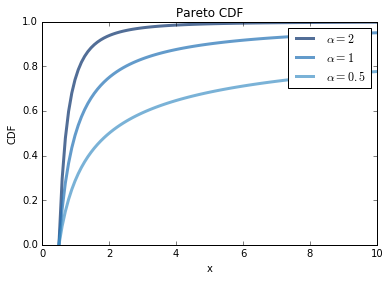

In [8]:
def MakeParetoCdf():
    """Generates a plot of the Pareto CDF."""
    xmin = 0.5

    thinkplot.PrePlot(3)
    for alpha in [2.0, 1.0, 0.5]:
        xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 10.0, n=100) 
        thinkplot.Plot(xs, ps, label=r'$\alpha=%g$' % alpha)
    
    thinkplot.Config(root='analytic_pareto_cdf',
                   title='Pareto CDF',
                   xlabel='x',
                   ylabel='CDF')
MakeParetoCdf()

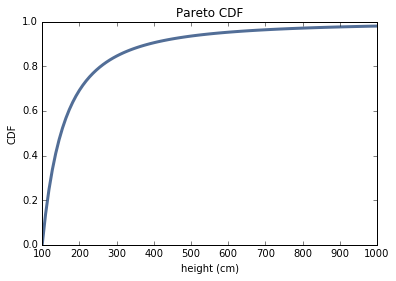

In [9]:
def MakeParetoCdf2():
    """Generates a plot of the CDF of height in Pareto World."""
    xmin = 100
    alpha = 1.7    
    xs, ps = thinkstats2.RenderParetoCdf(xmin, alpha, 0, 1000.0, n=100) 
    thinkplot.Plot(xs, ps)

    thinkplot.Config(root='analytic_pareto_height',
                   title='Pareto CDF',
                   xlabel='height (cm)',
                   ylabel='CDF',
                   legend=False)
MakeParetoCdf2()